# 配置环境

## 加载路径

In [3]:
import os
os.chdir("/content/drive/Othercomputers/我的笔记本电脑/A-GAN/暑期夏令营-刘坤明/E-StyleIntervention")

## pytorch版本

In [1]:
# 请确保pytorch版本为1.7.1
import torch
torch.__version__

'1.7.1'

### 使用网盘whl文件配置环境

In [ ]:
# 下载whl文件到本地
!pip download torch==1.7.1

In [ ]:
# 移动whl文件到云空间
!cp /content/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl /content/drive/MyDrive/torch

In [2]:
!pip install /content/drive/MyDrive/torch/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/torch/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 1.1 MB/s 
     |████████████████████████████████| 21.0 MB 171 kB/s 
     |████████████████████████████████| 23.2 MB 1.1 MB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 23.3 MB 1.4 MB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 22.1 MB 98.2 MB/s 
     |████████████████████████████████| 17.4 MB 50.9 MB/s 
     |████████████████████████████████| 17.3 MB 52.0 MB/s 
     |████████████████████████████████| 12.8 MB 27.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting

### 临时配置环境，重启后失效

In [3]:
!pip install torch==1.7.1 torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## C++ Extension

In [2]:
# https://blog.csdn.net/zhiweihongyan1/article/details/121975628
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 8.3 MB/s 


# Utils

In [4]:
from utils.image_process import *
from utils.codes_manipulation import *

# StyleIntervention

## 创建模型

In [12]:
#@title { display-mode: "form"}
latent_space_type = "S(style&torgb)" #@param ['S(style&torgb)', 'S(style)', 'S(torgb)']
intervention_space_type = "W" #@param ["Z", "W"]
save_result_images = False #@param {type:"boolean"}
file_path = "debug" #@param {type:"string"}
model_stat_path = "interventionCheckpoint/layer_8.pkl"#@param {type:"string"}
boundary_s_path = "boundaries/S_Space_style&torgb_boundary_0.45.npy" #@param {type:"string"}
boundary_inter_path = "boundaries/W_Space_boundary_0.45.npy" #@param {type:"string"}

import datetime
import torch
from loss.intervention import StyleIntervention

time_str = datetime.datetime.now().strftime('%m_%d_%H_%M')

# 特殊处理一下S隐空间的标识符
if latent_space_type.startswith("S"):
  if latent_space_type == "S(style&torgb)":
    time_str = time_str + "_st"
    space_type = "S_ST"
  elif latent_space_type == "S(style)":
    time_str = time_str + "_s"
    space_type = "S_S"
  elif latent_space_type == "S(torgb)":
    time_str = time_str + "_t"
    space_type = "S_T"
else:
  time_str = time_str + "_" + latent_space_type
  space_type = latent_space_type

generator = build_generator()
boundary_inter = np.load(boundary_inter_path)
boundary_s = np.load(boundary_s_path)

#计算delta_sn
delta_sn = boundary_s

if space_type == "S_ST" and delta_sn.shape[1]!=9088:
  raise SystemError("请选择正确的ST法向量")
elif space_type == "S_S" and delta_sn.shape[1]!=6048:
  raise SystemError("请选择正确的S法向量")
if space_type == "S_T" and delta_sn.shape[1]!=3040:
  raise SystemError("请选择正确的T法向量")

# 加载Intervention Model
intervention = StyleIntervention(space_type)
stat_dict = torch.load(model_stat_path)
intervention.load_state_dict(stat_dict)
intervention.eval()
intervention.cpu()

if save_result_images:
  root_dir = f"{file_path}/intervention_{time_str}"
  if save_result_images:
    os.mkdir(root_dir)

## 生成latent code

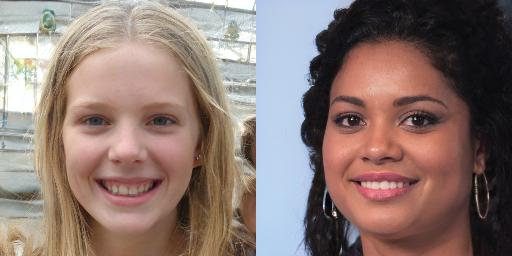

In [14]:
#@title { display-mode: "form", run: "auto" }

num_samples = 2 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 105 #@param {type:"slider", min:0, max:1000, step:1}
# 图片是否为竖直方向
is_vertical = False #@param {type:"boolean"}

# 生成交互空间code
inter_codes = sample_codes(generator, num_samples, intervention_space_type, noise_seed)
s_codes = transfer_latent_space(generator, inter_codes, intervention_space_type, "S")

# 方法一 计算出delta_sz后进行固定，后面利用这个delta_sz计算的delta_s
# 进行codes的改变
# 计算delta_sz
# new_z_codes = get_new_codes(z_codes, boundary_z, 1)
# new_s_codes = transfer_latent_space(generator, new_z_codes, "Z", "S")

# delta_sz = [[],[]]
# for i in range(2):
#   for j in range(len(new_s_codes[i])):
#     delta_sz[i].append(new_s_codes[i][j]-s_codes[i][j])

# if space_type == "S_ST":
#   delta_sz = s_space_code_process.cat_style_trgb(delta_sz[0], delta_sz[1])
# elif space_type == "S_S":
#   delta_sz = s_space_code_process.cat_codes(delta_sz[0])
# elif space_type == "S_T":
#   delta_sz = s_space_code_process.cat_codes(delta_sz[1])

# # 计算delta_s
# with torch.no_grad():
#   delta_s = intervention(delta_sz, delta_sn)
#   delta_s = delta_s.numpy()

images = easy_synthesis(s_codes, generator, space_type)
if is_vertical is False:
  fused_images = imshow(images, col=num_samples)
else:
  fused_images = imshow(images, col=1)

if save_result_images:
  save_img(fused_images, f"{root_dir}/origin_seed_{noise_seed}.png")

## 编辑属性

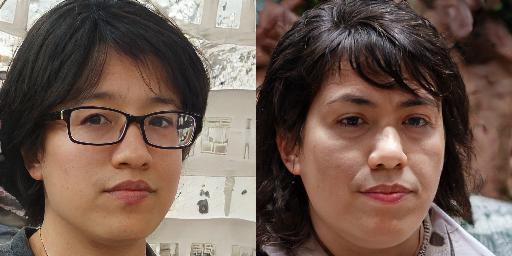

In [10]:
from math import e
#@title { display-mode: "form", run: "auto" }

smile = -19 #@param {type:"slider", min:-30, max:40, step:0.5}

# 方法二 改变smile后，利用新的smile计算delta_sz
# 计算delta_sz
new_inter_codes = get_new_codes(inter_codes, boundary_inter, 1, intervention_space_type)
new_s_codes = transfer_latent_space(generator, new_inter_codes, intervention_space_type, "S")

delta_sz = [[],[]]
for i in range(2):
  for j in range(len(new_s_codes[i])):
    delta_sz[i].append(new_s_codes[i][j]-s_codes[i][j])

if space_type == "S_ST":
  delta_sz = s_space_code_process.cat_style_trgb(delta_sz[0], delta_sz[1])
elif space_type == "S_S":
  delta_sz = s_space_code_process.cat_codes(delta_sz[0])
elif space_type == "S_T":
  delta_sz = s_space_code_process.cat_codes(delta_sz[1])

# 计算delta_s
with torch.no_grad():
  delta_s = intervention(delta_sz, delta_sn)
  delta_s = delta_s.numpy()

new_codes = get_new_codes(s_codes, delta_s, smile, space_type)

new_images = easy_synthesis(new_codes, generator, space_type)
if is_vertical is False:
  new_fused_images = imshow(new_images, col=num_samples)
else:
  new_fused_images = imshow(new_images, col=1)

if save_result_images:
  save_img(new_fused_images, f"{root_dir}/edited_eval_{smile}.png")